## Import of utils 

In [ ]:
# Create folder 
from utils.create_folder import create_simulation_folder
results_dir = create_simulation_folder()

## Topology

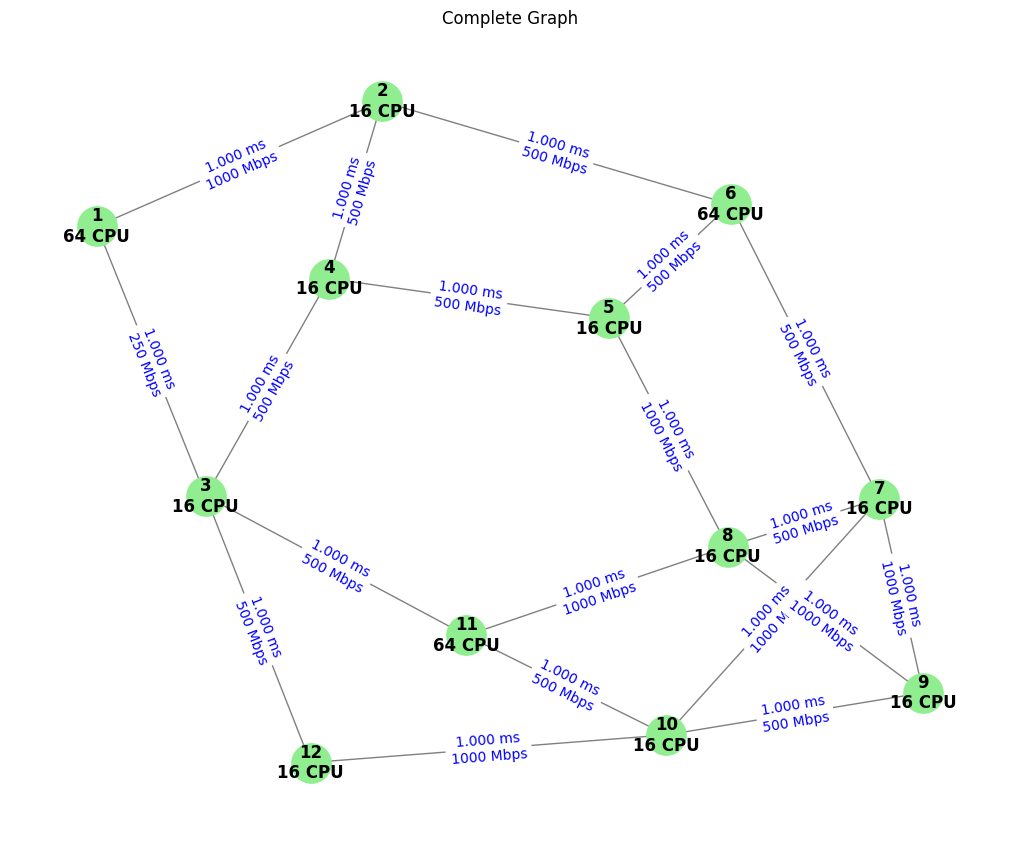

In [5]:
from utils.topology import topology_bayern, draw_graph, topologie_finlande, topology_brazil
from utils.generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()

draw_graph(G)


# Slices Generation 

In [6]:

from utils.generate_slices import generate_random_slices

# === Define corridor in the topology ===
vnf_profiles = [
    {"cpu": 2, "throughput": 40, "latency": 120},
    {"cpu": 4, "throughput": 50, "latency": 180},
    {"cpu": 6, "throughput": 60, "latency": 200},
    {"cpu": 8, "throughput": 75, "latency": 250}
]


In [ ]:
# ============================
# Imports (clean and complete)
# ============================

import os
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy
from datetime import datetime

# --- MILP modules ---
from milp.create_instance import create_instance
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

# --- Topologies ---
from utils.topology import topologie_finlande, topology_brazil

# --- Slice generation ---
from utils.generate_slices import generate_random_slices

# --- Heuristics ---
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.a_star_energy_aware import energy_aware_astar

# --- Metrics ---
from utils.metrics import (
    count_accepted_slices,
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
)

# If results_dir is used:
results_dir = "./results/"
os.makedirs(results_dir, exist_ok=True)


# --- Global MILP / experiment parameters ---
MILP_TIME_LIMIT = 300       # Time limit per MILP run (seconds)
ENTRY = 6                   # Fixed entry node
MAX_MILP_SLICES = 128       # Run MILP only if number of slices ≤ this
MAX_MILP_VNFS_TOTAL = 512   # Hard cap: total VNFs (num_slices × num_vnfs) ≤ this

# --- Topology ---
G = topologie_finlande()
ENTRY = 6

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid ---
param_grid = {
    "num_slices": [4, 6, 8, 10, 12, 16, 18, 20, 32],
    "num_vnfs_per_slice": [2, 3, 4],
    "seed": [1,2,3,4,5],
}

max_slices = max(param_grid["num_slices"])

# IMPORTANT: reset records before the main loop
records = []

# ------------------------------------------------------------------
# Main experiment loop with a fixed pool of slices per (vnf, seed)
# ------------------------------------------------------------------
for num_vnfs in param_grid["num_vnfs_per_slice"]:
    for seed in param_grid["seed"]:
        # Fix randomness once per (num_vnfs, seed)
        random.seed(seed)
        np.random.seed(seed)

        print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, VNFs={num_vnfs}, seed={seed} ===")

        # --- Generate a fixed pool of slices for this (num_vnfs, seed) ---
        slice_pool = generate_random_slices(
            G,
            vnf_profiles,
            num_slices=max_slices,
            num_vnfs_per_slice=num_vnfs,
            entry=ENTRY
        )

        # Sanity check (optional)
        if len(slice_pool) < max_slices:
            print(f"[WARN] slice_pool has only {len(slice_pool)} entries (expected {max_slices}).")

        # Now sweep num_slices by taking prefixes of the same pool
        for num_slices in param_grid["num_slices"]:
            total_vnfs = num_slices * num_vnfs

            print(f"\n[INFO] === Running Load Test: {num_slices} slices × {num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

            # Use the first num_slices from the fixed pool
            # deepcopy avoids unintended side-effects if algorithms modify slice objects
            slices = deepcopy(slice_pool[:num_slices])

            method_results = {}
            method_times = {}

            # --- Heuristics ---
            for name, func, args in [
                ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("Energy-Aware A*", energy_aware_astar,
                 (G, slices, node_capacity_base, link_capacity_base, 0.6, 0.4)),
            ]:
                start = time.time()
                try:
                    df_res, res_list = func(*args)
                    method_results[name] = res_list
                except Exception as e:
                    print(f"[ERROR] {name} failed: {e}")
                    method_results[name] = []
                method_times[name] = time.time() - start

            # --- MILP (only for small scenarios) ---
            if num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
                try:
                    print(f"\n[INFO][MILP] Running Gurobi MILP for {num_slices} slices ({total_vnfs} VNFs, limit {MILP_TIME_LIMIT}s)...")
                    start = time.time()

                    instance = create_instance(G, slices)
                    instance.entry_node = ENTRY

                    res = solve_gurobi(instance, msg=False, time_limit=MILP_TIME_LIMIT)
                    milp_adapter = MILPResultAdapterGurobi(res, instance)

                    method_results["MILP (Gurobi)"] = [milp_adapter]
                    method_times["MILP (Gurobi)"] = time.time() - start

                    print(f"[INFO][MILP] Completed in {method_times['MILP (Gurobi)']:.1f}s (status={res.status_str})")

                except Exception as e:
                    print(f"[ERROR][MILP] Failed: {e}")
                    method_results["MILP (Gurobi)"] = []
                    method_times["MILP (Gurobi)"] = None

            else:
                print(f"[SKIP][MILP] Skipped: {num_slices} slices × {num_vnfs} VNFs "
                      f"(total={total_vnfs}) exceeds limit ({MAX_MILP_SLICES} slices or {MAX_MILP_VNFS_TOTAL} VNFs).")

            # --- Compute metrics for all methods in this scenario ---
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })

# --- Save results ---
df_results = pd.DataFrame(records)

# Optional: safety check to ensure no duplicated (method, scenario)
dup = (df_results
       .groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"])
       .size()
       .reset_index(name="count"))
max_count = dup["count"].max()
print(f"[CHECK] Max repetitions of any (method, scenario) = {max_count}")
if max_count > 1:
    print("[WARN] There are duplicated scenarios in df_results!")
else:
    print("[OK] No duplicated scenarios per (method, num_slices, num_vnfs_per_slice, seed).")

output_path = os.path.join(results_dir, "scalability_results.csv")
df_results.to_csv(output_path, index=False)
print(f"\n[INFO] Results saved to {output_path}")

